# Supervised Machine Learning with GBM and Deep Learning

Tram Duong
<br>November 16, 2020

## Table of Contents:
* [Part 1: EDA and FE](#Part_1)
* [Part 2: Data Preparation](#Part_2)
* [Part 3: Supervised Learning](#Part_3)

## Part 1: EDA and FE <a class="anchor" id="Part_1"></a>
- Data Exploration
- Data Cleaning
- Feature Engineerings

In [1]:
#!pip install h2o

In [2]:
import numpy as np
import datetime
import h2o 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import roc_curve,auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read data
data = pd.read_csv("/Github/Data/XYZloan_default_selected_vars.csv")

### Data Preprocessing

#### Exploring the data
*Following cell output was not included to save space in report*

In [4]:
#data.info()
#data.describe()
#data.head()

#### The two columns  unnamed 0 and unnamed 0.1 do  not contain any important information for our target, leading me to drop them.

In [5]:
data = data.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

#### -99 and -999:

By looking through the dataset, there are numerious amount for "-99" and "-999" in the data. These values are most likely NAs that are handled differently by separate systems and seem to be hold no actual value. Thus, I will replace them with **na** for futher analysis. 

In [6]:
data = data.replace(-99, np.nan)
data = data.replace(-999, np.nan)

In [7]:
#data.head()

**Null Values**

In [8]:
# Proportuib of null value for the entire data
null_prop = round(sum(data.isnull().sum()) /(data.shape[1] * data.shape[0]),2) * 100
print("There is " + str(null_prop) + " % of the data is missing" )

There is 11.0 % of the data is missing


In [9]:
# Proportion of null values in each columns
null_cols = data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]
null_cols = null_cols.sort_values(ascending=False)

In [10]:
null_cols[:10]

TD048    99.99875
TD055    99.99875
TD062    99.99875
TD044    99.99625
TD051    99.99375
TD061    99.98750
TD054    99.98500
TD022    24.49750
TD023     9.57875
TD024     4.61750
dtype: float64

#### From this information, we can see that some features won't be relevant in our analysis as there are too many missing values (over 99% of the data is null). Therefore, I removed those variables as they do not provide useful information to work with.

In [11]:
# Create a list of dropped columns 
# The count function do not count null value.
data_prep = data[[column for column in data if data[column].count() / len(data) >= 0.1]]
# The list of droping features
null_list = []
for c in data.columns:
    if c not in data_prep.columns:
        null_list.append(c)

In [12]:
# Create the new dataframe we will work on
all_col = data.columns.to_list()
selected_columns = [column for column in all_col if column not in set(null_list)]
data = data[selected_columns]

In [13]:
# The data now has dropped 9 columns 
data.head()

,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,1,31,2,1,12,2017/7/6 10:21,ios,3,3,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,2,0,27,1,1,12,2017/4/6 12:51,h5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WEB
2,3,0,33,1,4,12,2017/7/1 14:11,h5,4,2,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,4,0,34,2,4,12,2017/7/7 10:10,android,5,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,5,0,47,2,1,12,2017/7/6 14:37,h5,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WEB


*Now I look at the others null values columns to see how to deal with them*

In [14]:
null_cols = data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]
null_cols = null_cols.sort_values(ascending=False)
#null_cols

After running some basic functions and checking the data dictionary, the columns that have missing values are all numeric type and are mostly related to the phone info, call details and credit center. Due to the type and the category of these variables, I assume that the missing values were either never provided to the company or were never recorded. 

For this dataset, instead of removing these missing valua, I will impute 0 to all of them in order to not exclude or mispresent any essential data. Thus, with 0 value, I can assume that there is no info for phone, call, bank, or loan to these users while still keeping the information available to me.

In [15]:
data = data.fillna(0)

***Categorical Data and Time Data***

From the dictionary and data exploration, there are 3 variables that not numeric datatypes which are AP005, AP006, and MB007. 
  - AP005: DATETIME
  - AP006: OS_TYPE
  - MB007: MOBILE_BRAND

In [16]:
data.select_dtypes(exclude=['int64', 'float64']).columns

Index(['AP005', 'AP006', 'MB007'], dtype='object')

In [17]:
AP006_df = pd.DataFrame(data.AP006.value_counts())
AP006_df

,AP006
h5,44246
ios,17159
android,17140
api,1455


AP006 is good for a categorical column as the entire column only consists of 4 different values.

In [18]:
MB007_df = pd.DataFrame(data.MB007.value_counts())
MB007_df['Cum_Percentage'] = MB007_df.cumsum()/ len(data) *100
#len(MB007_df)
#MB007_df[1:11]

*The column MB007 contains 112 categorical values, but there are 11 values contibute to approximately 95% of the data, including the "Noinfo" value. Thus, I renamed the other 5% of categorical values as "Other"*

In [19]:
data['MB007'] = data['MB007'].apply(lambda i: i if i in MB007_df[:11].index else 'Other')

In [20]:
from sklearn.preprocessing import LabelEncoder
def create_dummies(df):
    for i in df.columns:
        if df[i].dtypes=='object':
            print(i,'encoded')
            mask = ~df[i].isnull()
            label_encoder = LabelEncoder() 
            try:
                df[i][mask] = label_encoder.fit_transform(df[i][mask])
                df[i] = df[i].astype(int)
            except Exception as e:
                print(e)
    return df

In [21]:
data = create_dummies(data)

AP005 encoded
AP006 encoded
MB007 encoded


In [22]:
# AP004 is for loan term appication which only contains value of: 3,6,9,12. 
AP004_df = pd.DataFrame(data.AP004.value_counts())
#AP004_df
data = data.drop(columns = "AP004")

###### AP004

As the majority of users choose 12 month term, this column does would skew the analysis due to its large proportion value. Therefore, I dropped this column. 

***DateTime values***

The column AP005 represents the data and time recording. Instead of leaving it as be, I broke the information into two separate columns, date and time, to allow for easier formatting before removing the original column.

In [23]:
data['AP005'] = pd.to_datetime(data['AP005'])
data['Date'] = data['AP005'].dt.strftime('%d/%m/%Y')
data['Time'] = data['AP005'].dt.strftime('%H:%M')
data = data.drop(columns = "AP005")

**Duplicated values**

In [24]:
# Check duplciation values
duplicate = sum(data.id.duplicated())
print("There is " + str(duplicate) + " duplicated value" )

There is 0 duplicated value


## Part 2: Data Preparation <a class="anchor" id="Part_2"></a>


### Feature Correlation 

In [25]:
x = data.drop(columns = "loan_default", axis = 1)
y = data.loan_default.values

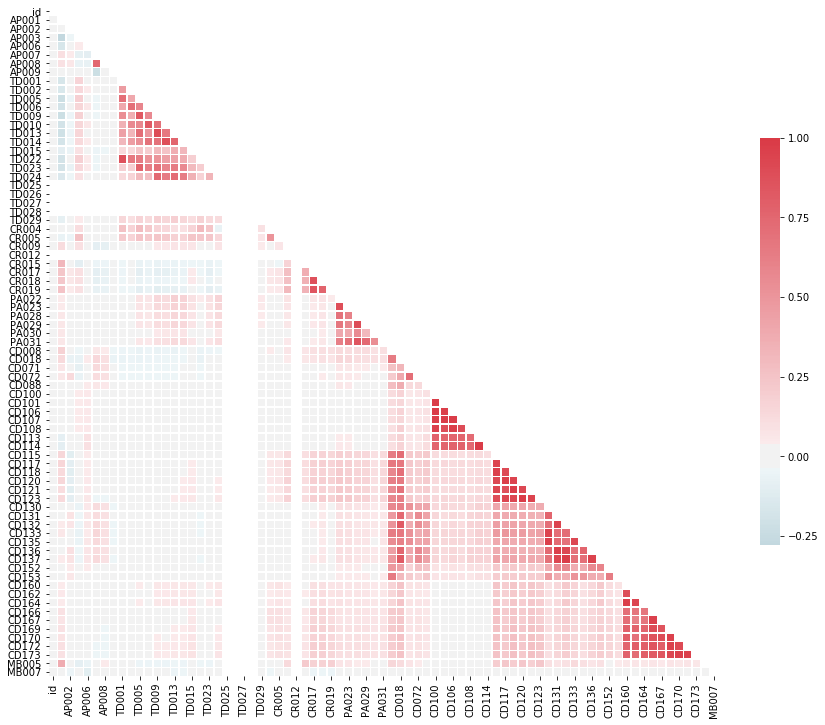

In [26]:
corr = x.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In general, feautures that are overly correlated do not improve model efficiency and also affect the performance of linear regression and random forest models, making the learning algorithms slower to create and train. Therefore, I removed highly correlated features to prevent multicollinearity throughout the following function:

In [27]:
# Function to remove collum with high correlation value
def correlation(dataset, threshold):
    """
    Remove columns that do exceeed correlation threshold
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

In [28]:
data = correlation(data, 0.80)
data_new = data.drop(columns = 'id')

Since the models I am planning only works with numerical features, I will convert whichever strings the data may contain to numeric values. Also, the date, time, object data do not work in these model. Therefore, I will drop these columns before working on the models. 

In [29]:
data_clean = data_new.drop(columns = ["Date", "Time"])

In [30]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 47 columns):
loan_default    80000 non-null int64
AP001           80000 non-null int64
AP002           80000 non-null int64
AP003           80000 non-null int64
AP006           80000 non-null int32
AP007           80000 non-null int64
AP008           80000 non-null int64
AP009           80000 non-null int64
TD001           80000 non-null int64
TD002           80000 non-null int64
TD005           80000 non-null int64
TD006           80000 non-null int64
TD013           80000 non-null int64
TD014           80000 non-null int64
TD015           80000 non-null int64
TD023           80000 non-null float64
TD024           80000 non-null float64
TD025           80000 non-null float64
TD026           80000 non-null float64
TD027           80000 non-null float64
TD028           80000 non-null float64
TD029           80000 non-null float64
CR004           80000 non-null int64
CR005           80000 non-

**Distribution Plots**

In [31]:
def plot_X_and_Y(var):

    z= data_clean.groupby(var)['loan_default'].agg(['count','mean']).reset_index() 
    z['count_pcnt'] = z['count']/z['count'].sum()
    x = z[var]
    y_mean = z['mean']
    count_pcnt = z['count_pcnt']
    ind = np.arange(0, len(x))
    width = .5

    fig = plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.bar(ind, count_pcnt, width, color='r')
    # plt.ylabel('X')
    plt.title(var + ' Distribution')
    plt.xticks(ind,x.tolist(), rotation=45)

    plt.subplot(122)
    plt.bar(ind, y_mean, width, color='b')
    #plt.ylabel('Y by X')
    plt.xticks(ind,x.tolist(), rotation=45)
    plt.tight_layout()
    plt.title('Response mean by ' + var)
    plt.show()

The clean data has 59 features, which is still a very large number to work with. After further exploration and looking at the variable dictionary, I saw that multiple variables contain a large range of values and thus are not supporting any insight to distribution plot. I removed these variables out of the list of features for distribution plotting.

In [32]:
features_dis = data_clean.drop(columns=['TD025','TD026','TD027','TD028','CR009','CR012',
                                      'PA022','PA028','PA030','CD008','CD018','CD071',
                                      'CD072','CD088','CD100','CD113','CD115','CD130',
                                      'CD131','CD152','CD153','CD160','CD166'])
features_dis = features_dis.columns

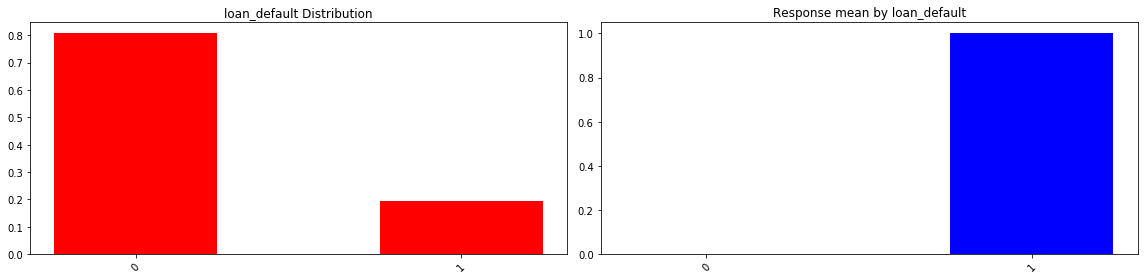

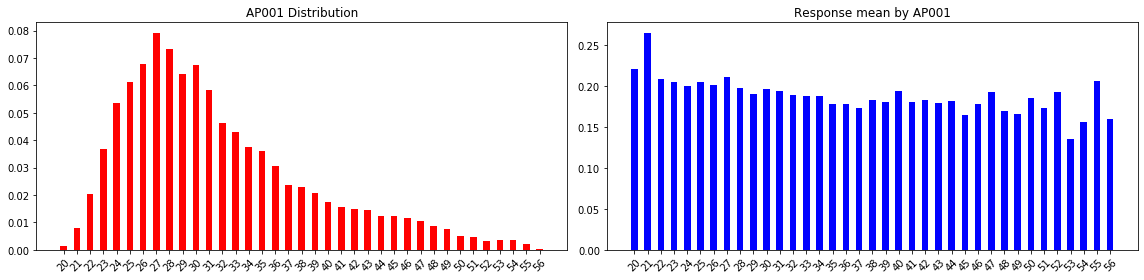

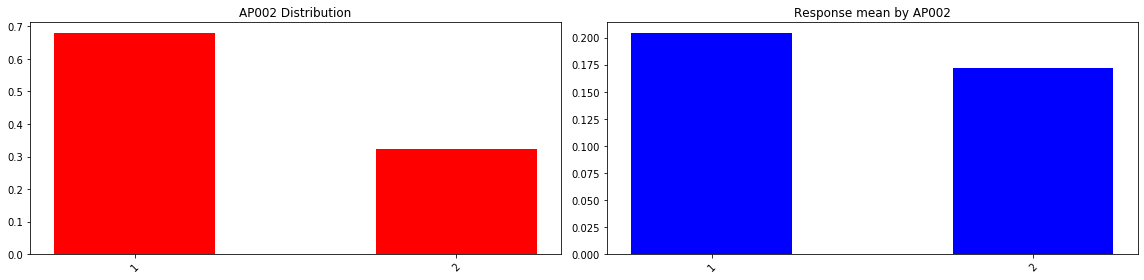

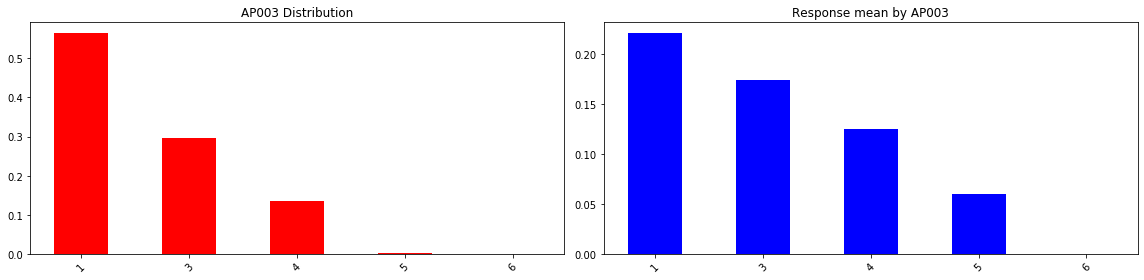

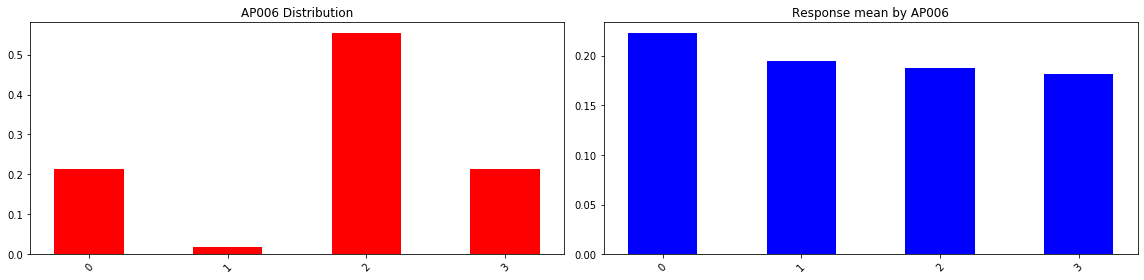

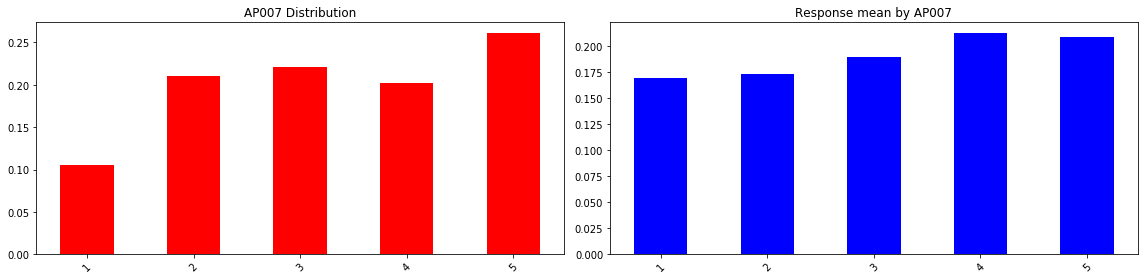

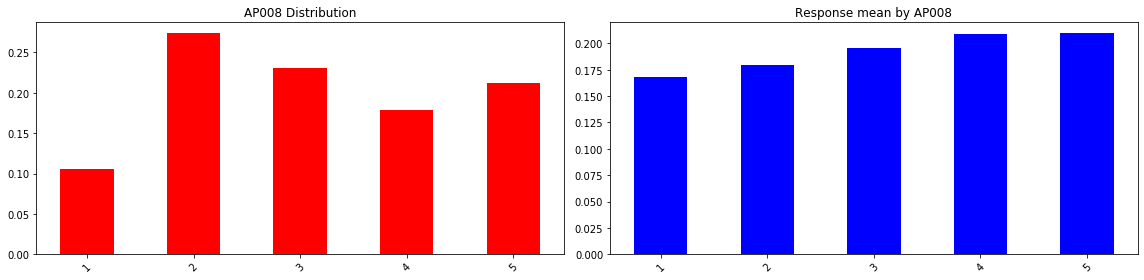

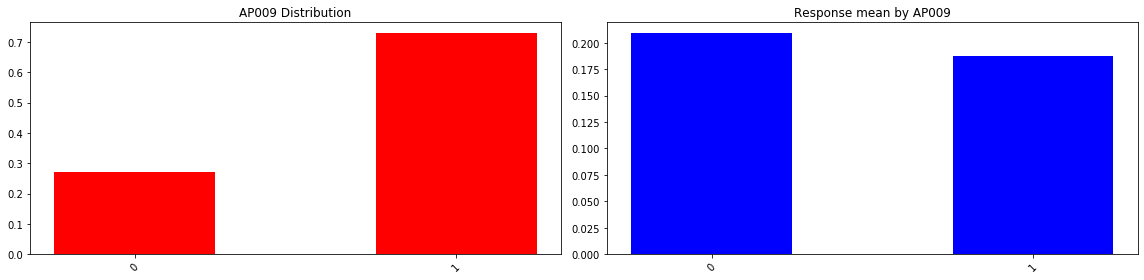

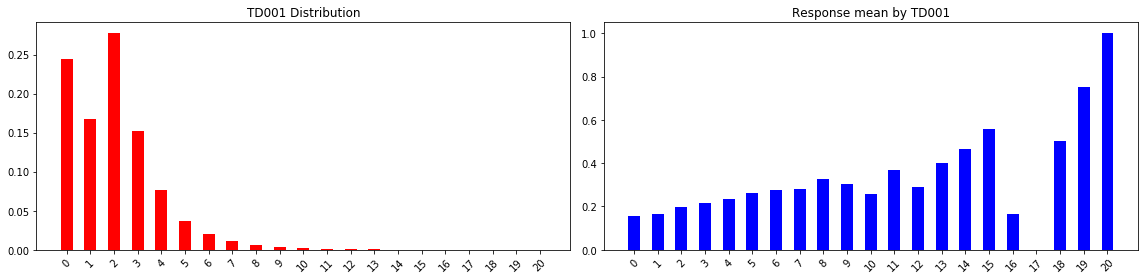

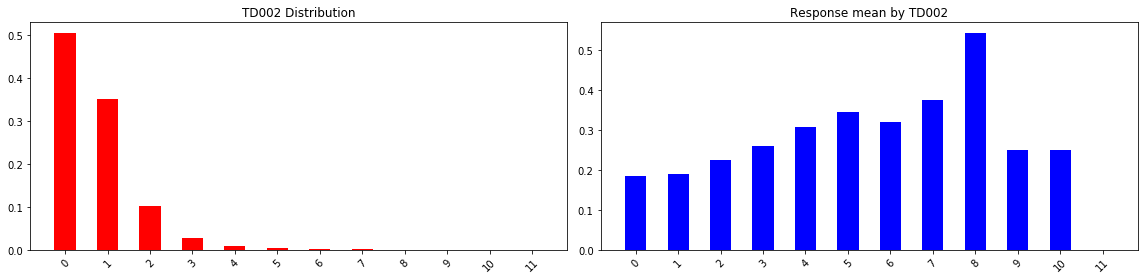

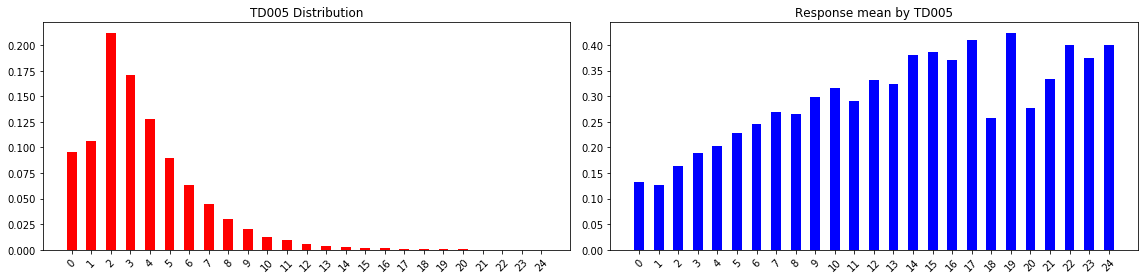

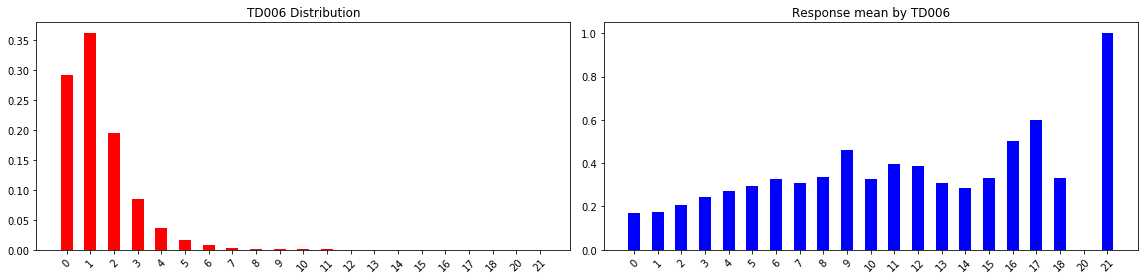

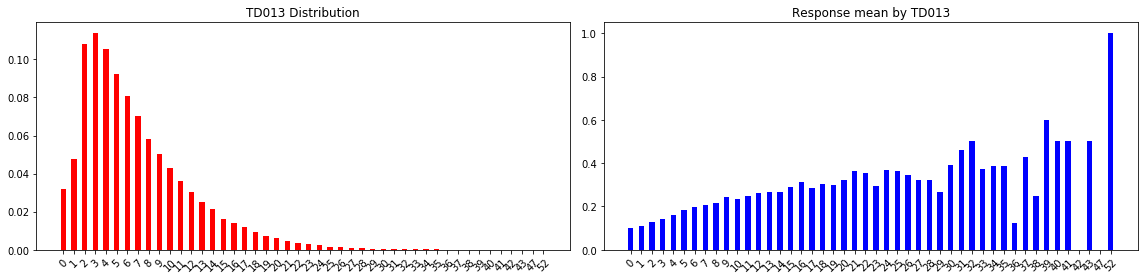

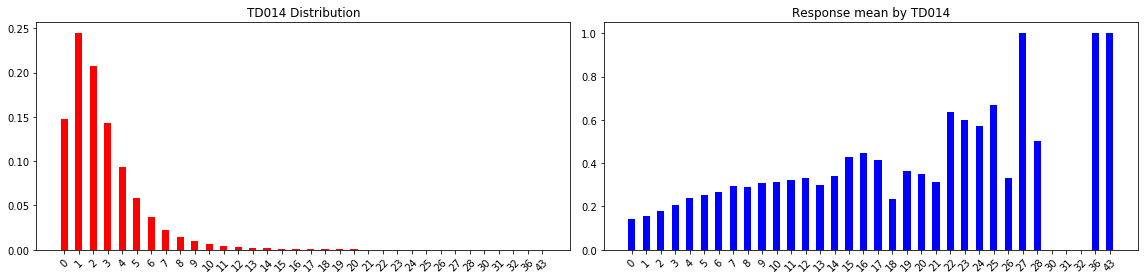

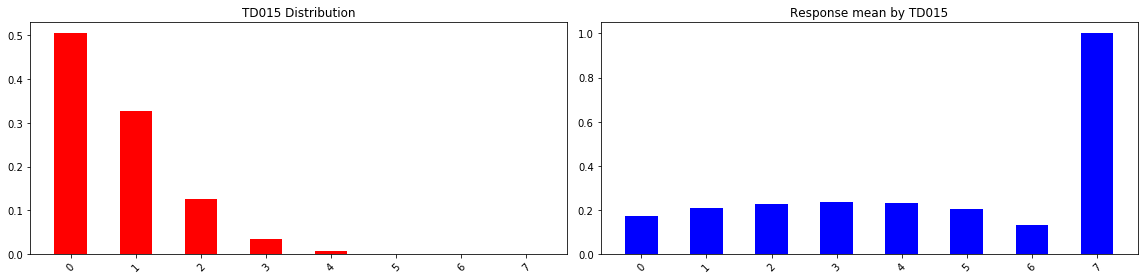

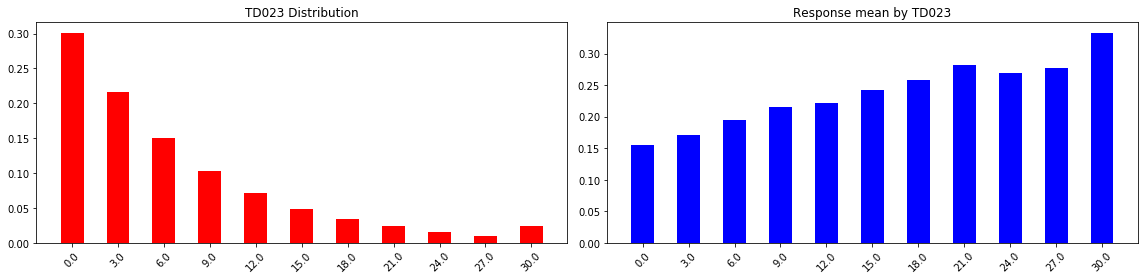

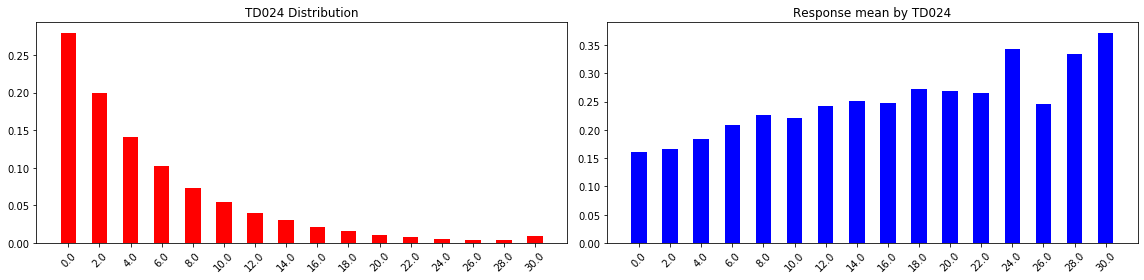

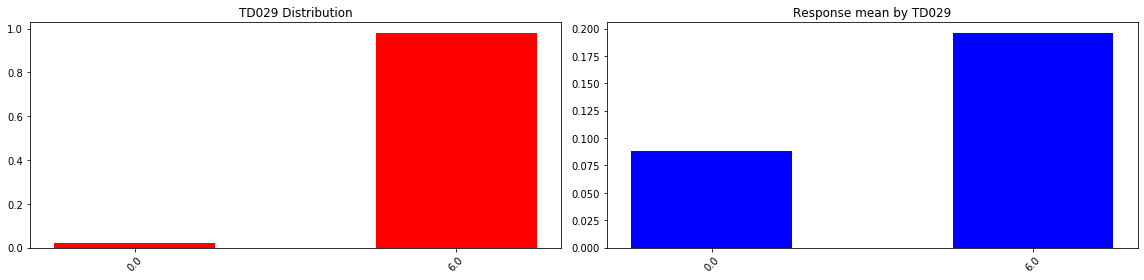

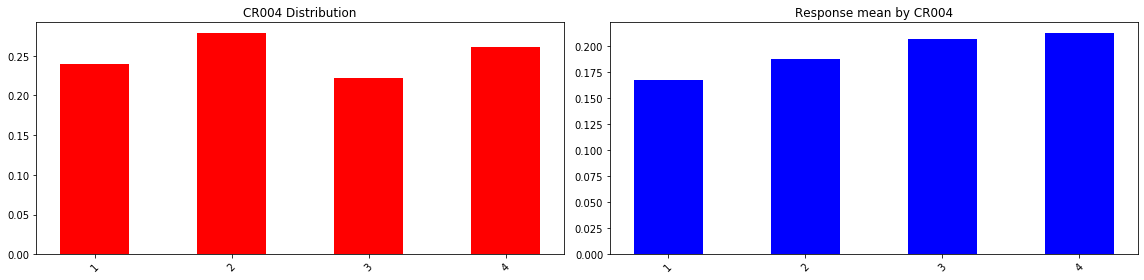

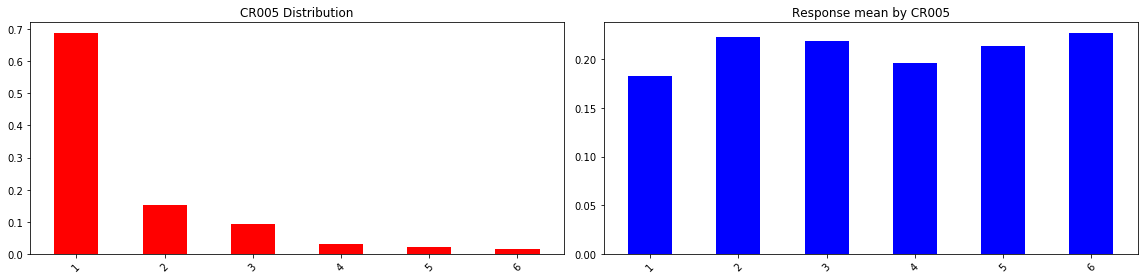

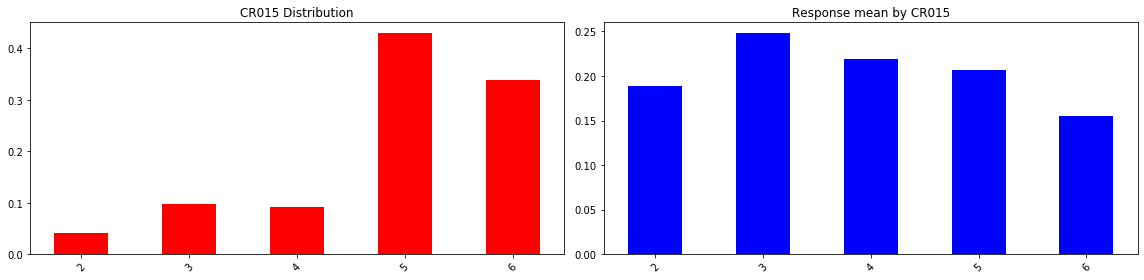

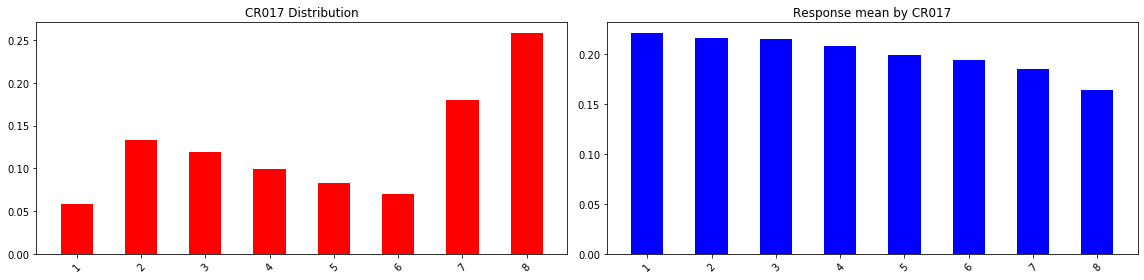

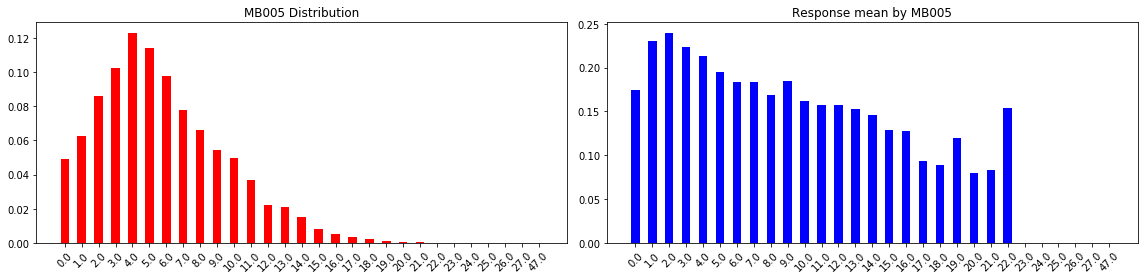

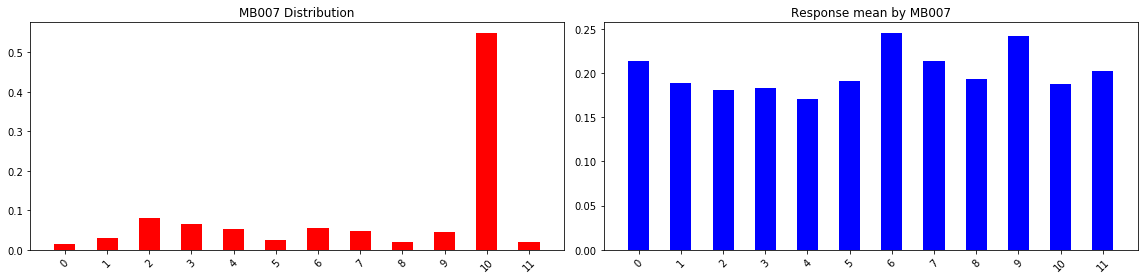

In [33]:
for i in features_dis:
    plot_X_and_Y(i)

## Part 3: Supervised Learning with Gradient Boosting Machine <a class="anchor" id="Part_3"></a>

GBM constructs a forward stage-wise additive model by implementing gradient descent in function space. GBMs have several hyperparameters that include the number of trees, the depth (or number of leaves), and the shrinkage (or learning rate). GBM is a boosting method, which builds on weak classifiers. The idea is to add a classifier at a time, so that the next classifier is trained to improve the already trained ensemble. 


#### Used functions throughout the modeling approach

In [34]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='lightblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false positive rate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()
    

#### Installing: H2O

In [35]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 14.0.1+7, mixed mode, sharing)
  Starting server from C:\Users\tramh\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\tramh\AppData\Local\Temp\tmpni5k843q
  JVM stdout: C:\Users\tramh\AppData\Local\Temp\tmpni5k843q\h2o_tramh_started_from_python.out
  JVM stderr: C:\Users\tramh\AppData\Local\Temp\tmpni5k843q\h2o_tramh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_tramh_at4jin
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.967 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


#### Split train-test data 

In [36]:
train, test = train_test_split(
    data_clean, test_size=0.30, random_state=23)

target = 'loan_default'
predictors = train.columns[1:]

In [37]:
# full data
train_full = h2o.H2OFrame(train)
test_full = h2o.H2OFrame(test)

# sample data to test 
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Model 1: 

I started by modeling using the train and test sample dataset. This approach helps to define the code performance before applying them into the entire dataset.

Given that we have an highly unbalanced dataset, I'm using the H2O balance_classes. The balance_classes option can be used to balance the class distribution. When enabled, H2O will either undersample the majority classes or oversample the minority classes.

[Reference](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html?highlight=AUC)

In [38]:
gbm_v1 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v1',
        max_depth = 7,
        min_rows = 100,
        nfolds = 10,
        ntrees = 10000,
        learn_rate = 0.01,
        stopping_rounds = 15, stopping_tolerance = 1e-5,
        sample_rate = 0.8,
        balance_classes = True,
        col_sample_rate = 0.8,
        score_tree_interval = 10,       
        seed=1234)

In [39]:
gbm_v1.train(list(predictors),target,training_frame=train_hex,validation_frame = test_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


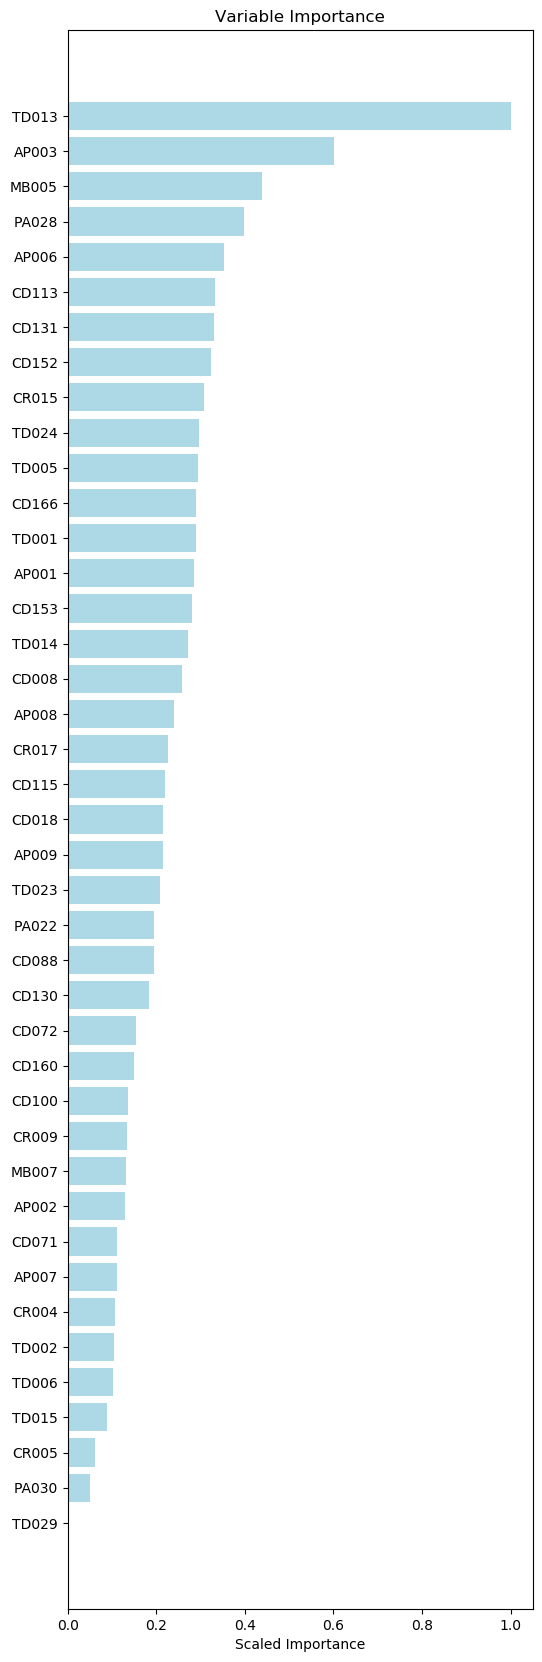

In [40]:
VarImp(gbm_v1)

In [41]:
predictions = gbm_v1.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,predict
0,0,0.158851
1,0,0.139201
2,0,0.068588
3,0,0.191419
4,0,0.210051


In [42]:
createGains(gbm_v1)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,95,145,240,95,145,0.20,0.08,46.8,2.03,12.0,39.58
1,240,58,182,480,153,327,0.33,0.17,93.6,1.63,16.0,31.87
2,240,70,170,720,223,497,0.48,0.26,140.4,1.59,22.0,30.97
3,240,56,184,960,279,681,0.60,0.35,187.2,1.49,25.0,29.06
4,240,48,192,1200,327,873,0.70,0.45,234.0,1.40,25.0,27.25
5,240,41,199,1440,368,1072,0.79,0.55,280.8,1.31,24.0,25.56
6,240,34,206,1680,402,1278,0.86,0.66,327.6,1.23,20.0,23.93
7,240,30,210,1920,432,1488,0.92,0.77,374.4,1.15,15.0,22.50
8,240,24,216,2160,456,1704,0.97,0.88,421.2,1.08,9.0,21.11


The gain table shows that the lift, K_S, and gain scores are fairly good. For example, let's look at decile 0.

- Lift = decile 0 of model 1 has 2.03 times greater lift than random selection.
- K_S= abs(cumulative % of total good loan applicants— cumulative % of total bad loan applicants) -> The higher the value, the better the model is at separating the positive cases from negative ones. 

gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



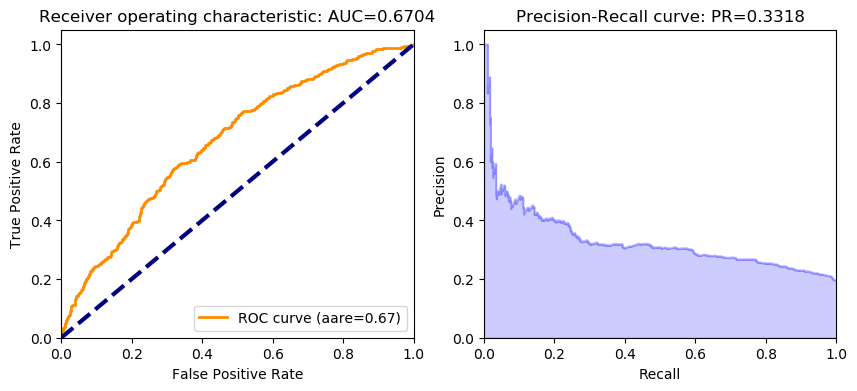

In [43]:
ROC_AUC(gbm_v1,test_hex,'loan_default')

The AUC and PR scores also have positive results (0.6704 and 0.3318). Overall, the parameters used in the first model are more likely to work well.  

### Model 2: 

After testing on small datasets and the results are promising, I apply the same code to the entire dataset. 

In [44]:
gbm_v2 =  H2OGradientBoostingEstimator(
        model_id = 'gbm_v2',
        max_depth = 6,
        min_rows = 50,
        nfolds = 10,
        ntrees = 10000,
        learn_rate = 0.01,
        stopping_rounds = 15, stopping_tolerance = 1e-5,
        sample_rate = 0.8,
        balance_classes = True,
        col_sample_rate = 0.8,
        score_tree_interval = 10,       
        seed=1234)

In [45]:
gbm_v2.train(list(predictors),target,training_frame=train_full,validation_frame = test_full)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [46]:
predictions_2 = gbm_v2.predict(test_full)
predictions_2.head()
test_scores_2 = test_full['loan_default'].cbind(predictions_2).as_data_frame()
test_scores_2.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,predict
0,0,0.364993
1,0,0.140810
2,0,0.176016
3,0,0.123112
4,1,0.389896


In [47]:
createGains(gbm_v2)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,98,142,240,98,142,0.21,0.07,46.8,2.09,14.0,40.83
1,240,73,167,480,171,309,0.37,0.16,93.6,1.83,21.0,35.62
2,240,61,179,720,232,488,0.50,0.25,140.4,1.65,25.0,32.22
3,240,56,184,960,288,672,0.62,0.35,187.2,1.54,27.0,30.00
4,240,42,198,1200,330,870,0.71,0.45,234.0,1.41,26.0,27.50
5,240,43,197,1440,373,1067,0.80,0.55,280.8,1.33,25.0,25.90
6,240,31,209,1680,404,1276,0.86,0.66,327.6,1.23,20.0,24.05
7,240,32,208,1920,436,1484,0.93,0.77,374.4,1.16,16.0,22.71
8,240,21,219,2160,457,1703,0.98,0.88,421.2,1.08,10.0,21.16


The gain table of model 2 results in slightly better scores compare to model 1, as well as the AUC and PR scores.

gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



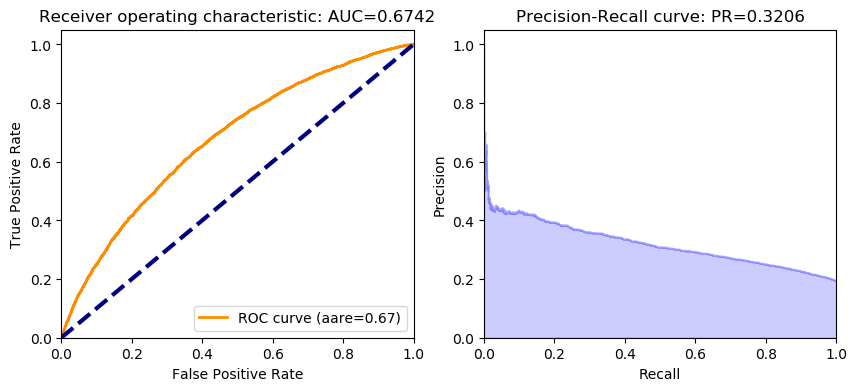

In [48]:
ROC_AUC(gbm_v2,test_full,'loan_default')

The model 2 (full data) use the same set of parameters like model 1 (sample data). The results of both models are positive. However, I would like to define the model with Hyperparameter Tuning approach using H2O Grid-search. 

### Model 3: Hyperparameter Tuning 
In this section, I used H2O Grid-search to find the optimal hyper-parameters for the model.

As 'loan_default' contains binary values represented by 0's and 1's, it is assumed to be numeric in H20 and is applied as such. Thus, it would be trained as a regression model instead of a binary classification model, and AUC is not allowed. Therefore, I will define the best model using the rmse and r2 scores. 

In [49]:
hyper_params_tune = {
    'learn_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.1],
    'max_depth':[4, 5, 6, 7, 8, 9, 10],
    'ntrees':[300, 500, 700, 900, 1100],
    'stopping_tolerance':[0.0001,0.00001]}

gbm_v3 = H2OGradientBoostingEstimator(
    stopping_rounds = 15,
    col_sample_rate = 0.80,
    sample_rate = 0.80,
    seed = 1234) 

#Build grid search with previously made GBM and hyper parameters
gbm_grid = H2OGridSearch(gbm_v3, hyper_params = hyper_params_tune,
                         search_criteria = {'strategy': "Cartesian"})

In [50]:
gbm_grid.train(list(predictors),target,training_frame=train_hex, validation_frame = test_hex)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [51]:
# Get the grid results, sorted by validation rmse and r2
sorted_gbm_grid = gbm_grid.get_grid(sort_by='rmse',decreasing=False)
sorted_gbm_grid1 = gbm_grid.get_grid(sort_by='r2',decreasing=True)
print(sorted_gbm_grid)
print(sorted_gbm_grid1)

       learn_rate max_depth ntrees stopping_tolerance  \
0            0.01         4    500             1.0E-5   
1            0.01         4    700             1.0E-5   
2            0.01         4    700             1.0E-4   
3            0.01         5    300             1.0E-5   
4            0.01         5    500             1.0E-5   
5            0.01         5    900             1.0E-5   
6            0.01         5    700             1.0E-5   
7            0.03         4    300             1.0E-5   
8            0.03         4    500             1.0E-5   
9            0.03         4    700             1.0E-5   
10           0.03         4    900             1.0E-5   
11           0.03         4   1100             1.0E-5   
12           0.01         7    500             1.0E-5   
13           0.01         4    900             1.0E-4   
14           0.01         4   1100             1.0E-4   
15           0.01         4    500             1.0E-4   
16           0.03         4    

[350 rows x 7 columns]

       learn_rate max_depth ntrees stopping_tolerance  \
0            0.01         4    500             1.0E-5   
1            0.01         4    700             1.0E-5   
2            0.01         4    700             1.0E-4   
3            0.01         5    300             1.0E-5   
4            0.01         5    500             1.0E-5   
5            0.01         5    900             1.0E-5   
6            0.01         5    700             1.0E-5   
7            0.03         4    300             1.0E-5   
8            0.03         4    500             1.0E-5   
9            0.03         4    700             1.0E-5   
10           0.03         4    900             1.0E-5   
11           0.03         4   1100             1.0E-5   
12           0.01         7    500             1.0E-5   
13           0.01         4    900             1.0E-4   
14           0.01         4   1100             1.0E-4   
15           0.01         4    500             1.0E-4   
16     

[350 rows x 7 columns]



Both r2 and rmse result in the same set of optimal hyperparameters as in the model summary above.The model metrics also show high scores on AUC and AUCPR (Both are approximately 0.95). Additionaly the other statistics also provide positive insights.

From the above, I will move forward to train the model with the full data.

In [52]:
best_gbm = sorted_gbm_grid.models[0]

In [53]:
print(best_gbm)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_Key_Frame__upload_a83cd714b687b66823ddb37c3d8a42e8.hex_model_python_1605423428293_1_model_211


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,500.0,500.0,117809.0,4.0,4.0,4.0,8.0,16.0,14.056




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.12525703770052998
RMSE: 0.3539167101176914
MAE: 0.27034507821502174
RMSLE: 0.24615938231141338
Mean Residual Deviance: 0.12525703770052998

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.14733790306641015
RMSE: 0.38384619714986123
MAE: 0.29291711617784505
RMSLE: 0.26889468971732816
Mean Residual Deviance: 0.14733790306641015

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-11-15 02:14:43,6 min 56.088 sec,0.0,0.394542,0.311327,0.155663,0.396207,0.312643,0.156980
1,,2020-11-15 02:14:43,6 min 56.103 sec,1.0,0.394291,0.311160,0.155465,0.396069,0.312560,0.156871
2,,2020-11-15 02:14:43,6 min 56.103 sec,2.0,0.394070,0.310968,0.155291,0.395926,0.312409,0.156758
3,,2020-11-15 02:14:43,6 min 56.119 sec,3.0,0.393845,0.310783,0.155114,0.395819,0.312304,0.156673
4,,2020-11-15 02:14:43,6 min 56.119 sec,4.0,0.393618,0.310623,0.154935,0.395684,0.312190,0.156566
5,,2020-11-15 02:14:44,6 min 56.135 sec,5.0,0.393382,0.310447,0.154749,0.395601,0.312118,0.156500
6,,2020-11-15 02:14:44,6 min 56.150 sec,6.0,0.393171,0.310251,0.154583,0.395465,0.311966,0.156393
7,,2020-11-15 02:14:44,6 min 56.150 sec,7.0,0.392968,0.310081,0.154424,0.395373,0.311867,0.156320
8,,2020-11-15 02:14:44,6 min 56.166 sec,8.0,0.392730,0.309890,0.154237,0.395236,0.311750,0.156211
9,,2020-11-15 02:14:44,6 min 56.166 sec,9.0,0.392516,0.309744,0.154069,0.395104,0.311645,0.156107



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,861.343628,1.000000,0.101128
1,AP003,554.145630,0.643350,0.065061
2,PA028,375.473419,0.435916,0.044083
3,AP006,349.594452,0.405871,0.041045
4,TD024,339.329895,0.393954,0.039840
5,TD005,308.948090,0.358682,0.036273
6,CD113,301.164825,0.349645,0.035359
7,MB005,293.567383,0.340825,0.034467
8,TD001,290.571106,0.337346,0.034115
9,CR015,288.270782,0.334676,0.033845



See the whole table with table.as_data_frame()



In [54]:
best_gbm.train(list(predictors),target,training_frame=train_full)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [55]:
# Prediction with the best model
predictions_3 = best_gbm.predict(test_full)
predictions_3.head()
test_scores_3 = test_full['loan_default'].cbind(predictions_3).as_data_frame()
test_scores_3.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,predict
0,0,0.351301
1,0,0.157845
2,0,0.174167
3,0,0.148247
4,1,0.459149


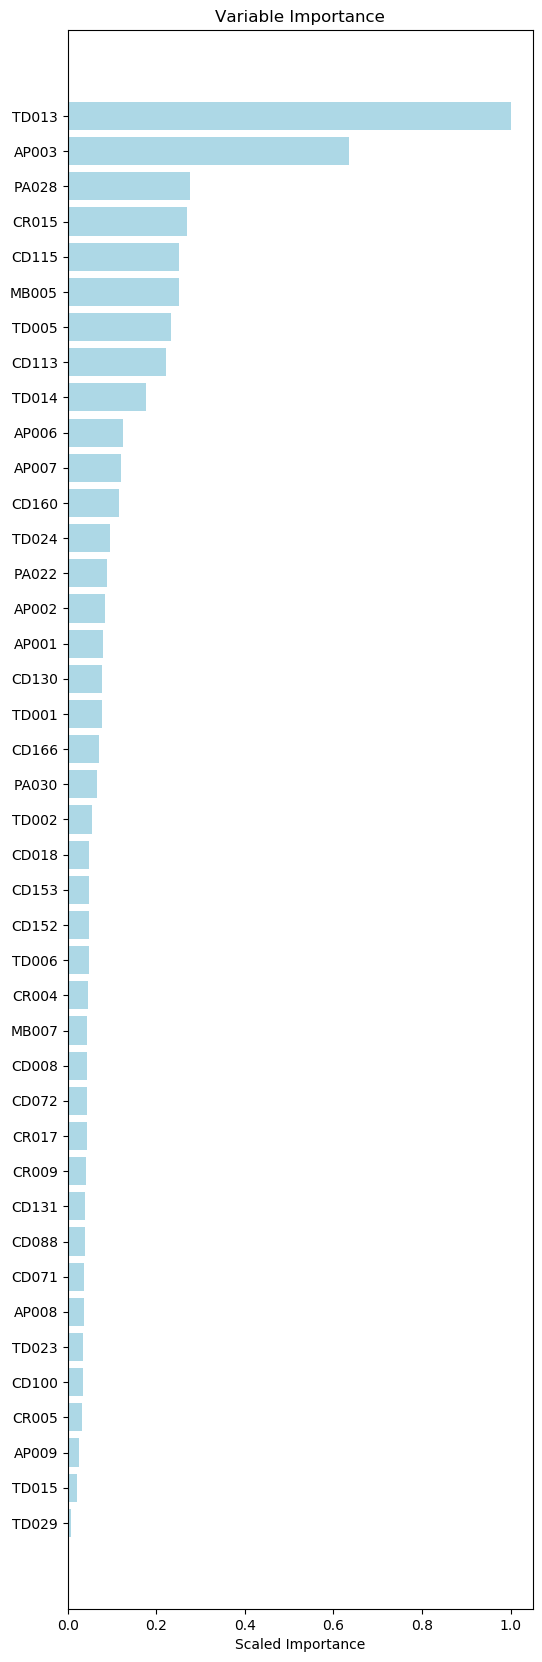

In [56]:
VarImp(best_gbm)

In [57]:
createGains(best_gbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,97,143,240,97,143,0.21,0.07,46.8,2.07,14.0,40.42
1,240,67,173,480,164,316,0.35,0.16,93.6,1.75,19.0,34.17
2,240,65,175,720,229,491,0.49,0.25,140.4,1.63,24.0,31.81
3,240,54,186,960,283,677,0.60,0.35,187.2,1.51,25.0,29.48
4,240,41,199,1200,324,876,0.69,0.45,234.0,1.38,24.0,27.00
5,240,46,194,1440,370,1070,0.79,0.55,280.8,1.32,24.0,25.69
6,240,28,212,1680,398,1282,0.85,0.66,327.6,1.21,19.0,23.69
7,240,38,202,1920,436,1484,0.93,0.77,374.4,1.16,16.0,22.71
8,240,20,220,2160,456,1704,0.97,0.88,421.2,1.08,9.0,21.11


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



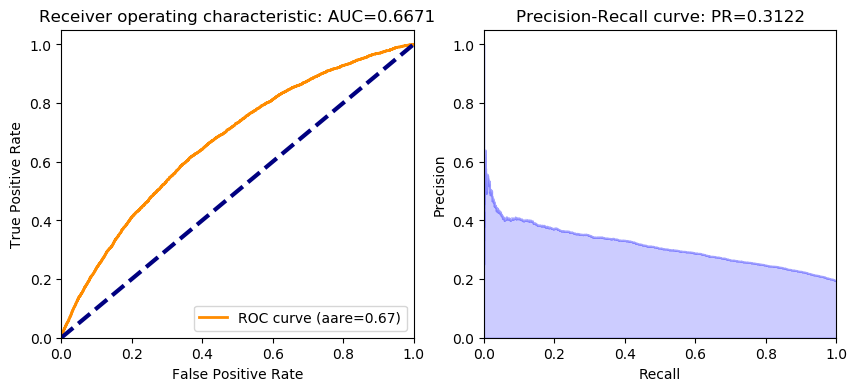

In [58]:
ROC_AUC(best_gbm,test_full,'loan_default')

The best model has a result similar like the other previous models. However, I experienced faster running time with the selected model, providing me similar results in less time. This insight could be due to the much lower number of trees in the best model (500) compared to the other ones (10000).

### Deep Learning

While H2O Deep Learning has many parameters, it was designed to be just as easy to use as the other supervised training methods in H2O. Early stopping, automatic data standardization and handling of categorical variables and missing values and adaptive learning rates (per weight) reduce the amount of parameters the user has to specify. Often, it's just the number and sizes of hidden layers, the number of epochs and the activation function and maybe some regularization techniques. 

* input_dropout_ratio: Specify the input layer dropout ratio to improve generalization. Suggested values are 0.1 or 0.2. This option defaults to 0. 
* hidden: Specify the hidden layer sizes (e.g., 100,100). The value must be positive. This option defaults to (200,200).
* epochs: Specify the number of times to iterate (stream) the dataset. The value can be a fraction. This option defaults to 10.

[References](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html)

The data has: 
* 80000 rows, 47 columns (variables)
* These 46 variables are all numerical 
* 1 target variable (0 or 1)

The H2O Architecture uses the hidden keyword to control model network architecture. Hidden takes a list of integers, representing the number of nodes in each layer.
* 1. Single layer, 1000 nodes
* 2. Two layers, 200 nodes each
* 3. Three layers, 7 nodes each (trying with square root of 47) 
* 4. Four layers,  15 -> 20 -> 25 -> 30

Epochs = 3000. 

[Reference](https://github.com/h2oai/h2o-tutorials)

#### Model 1: 1000 nodes and one layer 

In [59]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
DL_modl_1 = H2ODeepLearningEstimator(
    distribution="tweedie",
    activation="RectifierWithDropout",
    hidden=[1000],
    input_dropout_ratio=0.1,
    sparse=True,
    l1=1e-5,
    epochs=3000,
    seed =1234)

In [60]:
DL_modl_1.train(
    x=list(predictors),
    y=target,
    training_frame=train_hex,
    validation_frame=test_hex)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [61]:
createGains(DL_modl_1)

deeplearning prediction progress: |███████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,89,151,240,89,151,0.19,0.08,46.8,1.90,11.0,37.08
1,240,71,169,480,160,320,0.34,0.17,93.6,1.71,17.0,33.33
2,240,58,182,720,218,502,0.47,0.26,140.4,1.55,21.0,30.28
3,240,62,178,960,280,680,0.60,0.35,187.2,1.50,25.0,29.17
4,240,44,196,1200,324,876,0.69,0.45,234.0,1.38,24.0,27.00
5,240,36,204,1440,360,1080,0.77,0.56,280.8,1.28,21.0,25.00
6,240,36,204,1680,396,1284,0.85,0.66,327.6,1.21,19.0,23.57
7,240,33,207,1920,429,1491,0.92,0.77,374.4,1.15,15.0,22.34
8,240,23,217,2160,452,1708,0.97,0.88,421.2,1.07,9.0,20.93


deeplearning prediction progress: |███████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



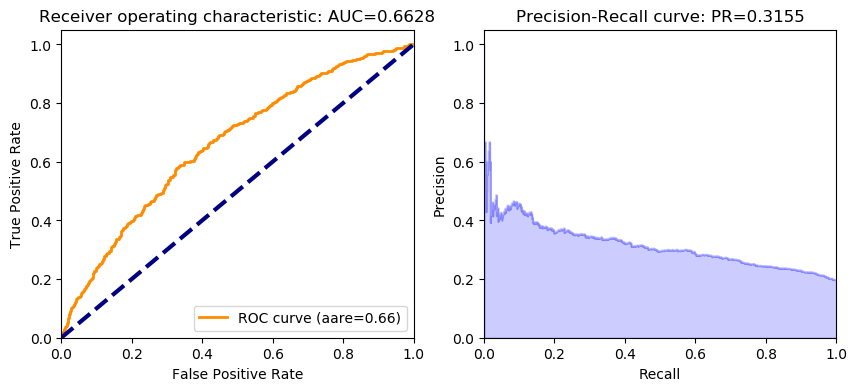

In [62]:
ROC_AUC(DL_modl_1,test_hex,'loan_default')

The first deep learning model has the lowest statistics scores in the gain table and also in AUC score. However, this is a random hidden with only 1 layer and 1000 nodes. I will try different approaches in creating hidden set to determine the best approach for deep learning. 

#### Model 2: 2 layers and 500 nodes each

The approach here is increase number of layers to 2 and decrease number of neurons to 500 for each layer.

In [63]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
DL_modl_2 = H2ODeepLearningEstimator(
    distribution="tweedie",
    activation="RectifierWithDropout",
    hidden=[500,500],
    input_dropout_ratio=0.1,
    sparse=True,
    l1=1e-5,
    epochs=3000,
    seed =1234)

In [64]:
DL_modl_2.train(
    x=list(predictors),
    y=target,
    training_frame=train_hex,
    validation_frame=test_hex)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [65]:
createGains(DL_modl_2)

deeplearning prediction progress: |███████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,97,143,240,97,143,0.21,0.07,46.8,2.07,14.0,40.42
1,240,66,174,480,163,317,0.35,0.16,93.6,1.74,19.0,33.96
2,240,56,184,720,219,501,0.47,0.26,140.4,1.56,21.0,30.42
3,240,51,189,960,270,690,0.58,0.36,187.2,1.44,22.0,28.12
4,240,50,190,1200,320,880,0.68,0.46,234.0,1.37,22.0,26.67
5,240,51,189,1440,371,1069,0.79,0.55,280.8,1.32,24.0,25.76
6,240,33,207,1680,404,1276,0.86,0.66,327.6,1.23,20.0,24.05
7,240,28,212,1920,432,1488,0.92,0.77,374.4,1.15,15.0,22.50
8,240,27,213,2160,459,1701,0.98,0.88,421.2,1.09,10.0,21.25


deeplearning prediction progress: |███████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



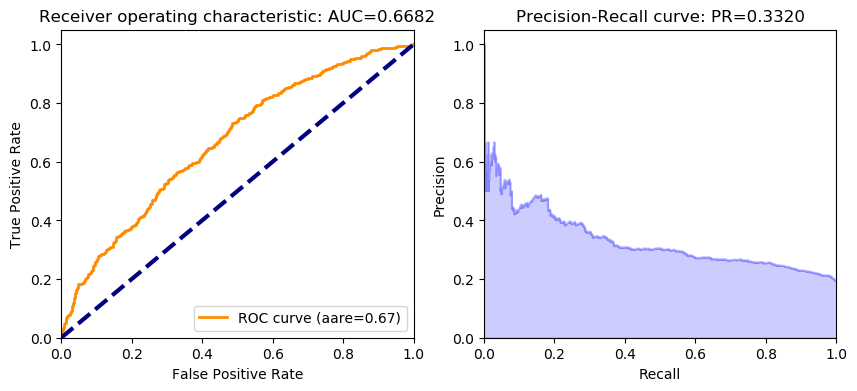

In [66]:
ROC_AUC(DL_modl_2,test_hex,'loan_default')

From this approach, the lift score increases again, as well as the AUC and PR scores. Therefore, I am going to follow the same approach.

#### Model 3: 3 layers with 7 nodes each (~equals the square root of 47 variables)

Since the data contains 47 variables, I again increase the number of layers to 3 and decreased number of neurons to 7. Considering if it would increase the model performance by using square root of total number of variables

In [67]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
DL_modl_3 = H2ODeepLearningEstimator(
    distribution="tweedie",
    activation="RectifierWithDropout",
    hidden=[7,7,7],
    input_dropout_ratio=0.2,
    sparse=True,
    l1=1e-5,
    epochs=3000,
    seed =1234)

In [68]:
DL_modl_3.train(
    x=list(predictors),
    y=target,
    training_frame=train_hex,
    validation_frame=test_hex)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [69]:
createGains(DL_modl_3)

deeplearning prediction progress: |███████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,101,139,240,101,139,0.22,0.07,46.8,2.16,15.0,42.08
1,240,58,182,480,159,321,0.34,0.17,93.6,1.70,17.0,33.12
2,240,70,170,720,229,491,0.49,0.25,140.4,1.63,24.0,31.81
3,240,53,187,960,282,678,0.60,0.35,187.2,1.51,25.0,29.38
4,240,39,201,1200,321,879,0.69,0.45,234.0,1.37,24.0,26.75
5,240,28,212,1440,349,1091,0.75,0.56,280.8,1.24,19.0,24.24
6,240,47,193,1680,396,1284,0.85,0.66,327.6,1.21,19.0,23.57
7,240,35,205,1920,431,1489,0.92,0.77,374.4,1.15,15.0,22.45
8,240,22,218,2160,453,1707,0.97,0.88,421.2,1.08,9.0,20.97


deeplearning prediction progress: |███████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



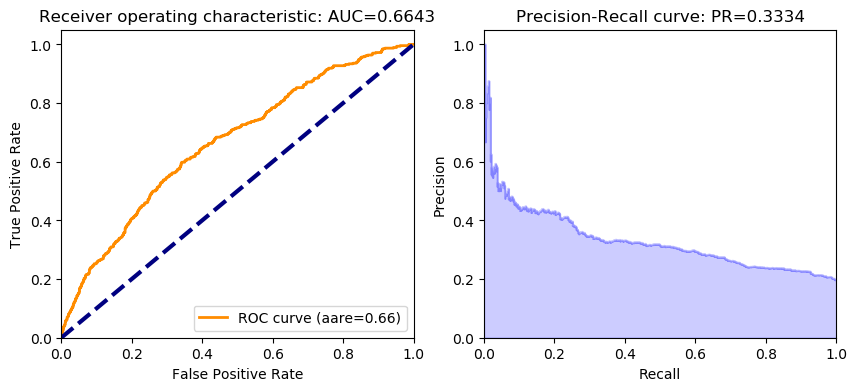

In [70]:
ROC_AUC(DL_modl_3,test_hex,'loan_default')

This model return as the highest lift score (2.16) so far, as well as the AUC and PR scores. Now, I want to try the same approach with the last model. 

#### Model 4: 4 layers which 15, 20, 25, 30 nodes 

In this model, I increase the number of layers to 4 and randomly picked number of neurons for each layer, starting from 15 and increasing 5 nodes per each layer. 

In [71]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
DL_modl_4 = H2ODeepLearningEstimator(
    distribution="tweedie",
    activation="RectifierWithDropout",
    hidden=[15,20,25,30],
    input_dropout_ratio=0.2,
    sparse=True,
    l1=1e-5,
    epochs=3000,
    seed =1234)

In [72]:
DL_modl_4.train(
    x=list(predictors),
    y=target,
    training_frame=train_hex,
    validation_frame=test_hex)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [73]:
createGains(DL_modl_4)

deeplearning prediction progress: |███████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,91,149,240,91,149,0.19,0.08,46.8,1.94,11.0,37.92
1,240,68,172,480,159,321,0.34,0.17,93.6,1.70,17.0,33.12
2,240,63,177,720,222,498,0.47,0.26,140.4,1.58,21.0,30.83
3,240,53,187,960,275,685,0.59,0.35,187.2,1.47,24.0,28.65
4,240,41,199,1200,316,884,0.68,0.46,234.0,1.35,22.0,26.33
5,240,45,195,1440,361,1079,0.77,0.56,280.8,1.29,21.0,25.07
6,240,37,203,1680,398,1282,0.85,0.66,327.6,1.21,19.0,23.69
7,240,34,206,1920,432,1488,0.92,0.77,374.4,1.15,15.0,22.50
8,240,16,224,2160,448,1712,0.96,0.89,421.2,1.06,7.0,20.74


deeplearning prediction progress: |███████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



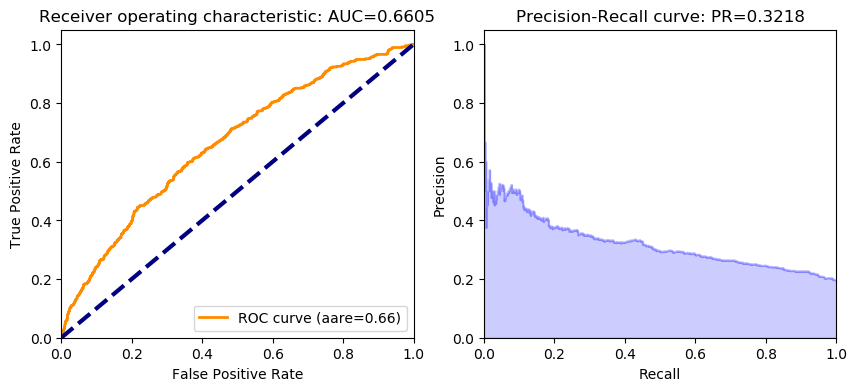

In [74]:
ROC_AUC(DL_modl_4,test_hex,'loan_default')

Even though the result in this model is not bad, it is not good compared to previous ones.  

### Conclusion

For Gradient Boosting models, the predictive power does not increase when we apply optimal hyperparementers as it had similar results to the previous iterations. However, the running time for the best model is faster which should also be considered for optimization. Additionally, from my observations, GBM models aim to find optimal linear combination of trees by training (assume final model is the weighted sum of predictions of individual trees) in relation to given train data, and performed much better than RF models, such as the ones we used in the previous assignment. This leads me to believe that the dataset prefer more extra tunning (GBM) and less claasifier approach (RF).  

For the deep learning model, the predictive power increased more when I increased the number of layers and decreased the number of neurons in each layer. Furthermore, the approach of using the square root of total number of features created the best model out of all iterations. 

Lastly, the dataset has a wide-range of dates and times, which may be investigated further because the variable seems like a good choice for prediction. I also considered the data preprocessing as I believe generating features that have predictive power can improve model performance overall.